In [19]:
# clone repo https://github.com/cloneofsimo/lora.git then go to training_scripts folder

!pip install -q -r ../requirements.txt
# install lora_diffusion cli from downloaded git repo:
!pip install -q -e ../
!pip install -q mediapipe


In [ ]:
# based on v0.1.1 of lora @ https://github.com/cloneofsimo/lora/releases/tag/v0.1.1

MODEL_NAME="runwayml/stable-diffusion-v1-5"
INSTANCE_DIR="./simu_liu" # see the dataset filenames for the caption structure
OUTPUT_DIR="./outputs/simu_liu"

# init tokens are the classes you set on your filename caption separated by pipes "|"
INITIALIZER_TOKENS="person|man"

# placeholder tokens are the tokens that may be used per init tokens (e.g. at your prompt: "<sl1> person", "<sl2> man" depending on which init token you want to use)
PLACEHOLDER_TOKENS="<sl1>|<sl2>"

# placeholder token at data merely replaces the <sl> token from the caption filenames with the placeholder tokens
PLACEHOLDER_TOKEN_AT_DATA="<sl>|<sl1><sl2>"


# ~12GB VRAM usage, can now use --gradient_checkpointing for less vram? or potentially xformers?
!lora_pti \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --train_text_encoder \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_checkpointing \
  --gradient_accumulation_steps=1 \
  --learning_rate_unet=3e-4 \
  --learning_rate_text=3e-4 \
  --learning_rate_ti=1e-3 \
  --color_jitter \
  --lr_scheduler="constant" \
  --lr_warmup_steps=100 \
  --placeholder_tokens="$PLACEHOLDER_TOKENS" \
  --placeholder_token_at_data="$PLACEHOLDER_TOKEN_AT_DATA" \
  --initializer_tokens="$INITIALIZER_TOKENS" \
  --save_steps=100 \
  --max_train_steps_ti=500 \
  --max_train_steps_tuning=1000 \
  --perform_inversion=True \
  --use_template="object"\
  --weight_decay_ti=0.1 \
  --weight_decay_lora=0.001\
  --continue_inversion_lr=1e-4\
  --device="cuda:0"\
  --use_face_segmentation_condition

100%|██████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.96it/s]


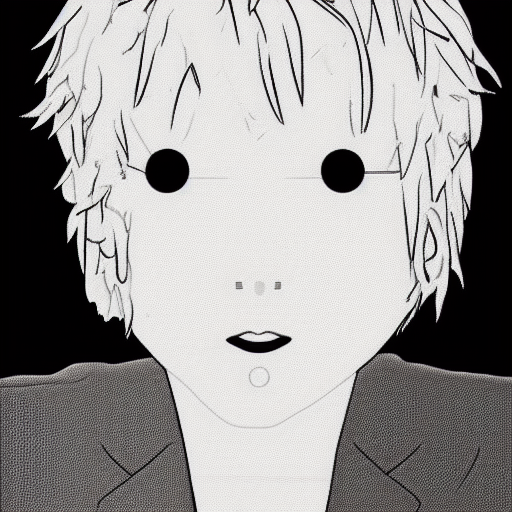

In [13]:
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch

model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    "cuda"
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

prompt = "<x1> person"
torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image

<sl1>
<sl2>


100%|██████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.60it/s]


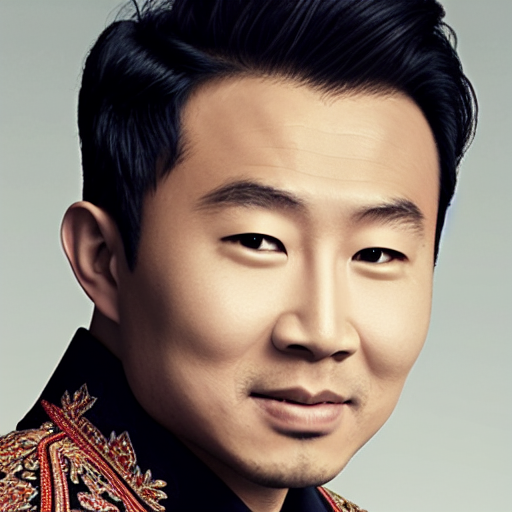

In [14]:
from lora_diffusion import monkeypatch_lora, tune_lora_scale, patch_pipe

patch_pipe(
    pipe,
    "./outputs/simu_liu/step_1000.safetensors",
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
)

tune_lora_scale(pipe.unet, 1.00)
prompt = "<sl2> man"
torch.manual_seed(100)
image = pipe(prompt, num_inference_steps=50, guidance_scale=4.5).images[0]
image.save("./outputs/images/sample.jpg")
image

100%|██████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.19it/s]


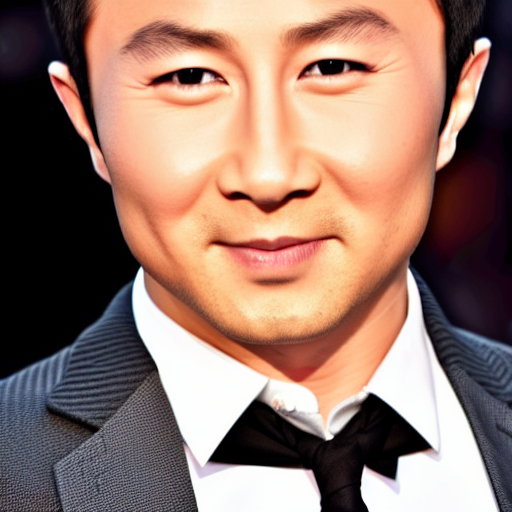

In [15]:
tune_lora_scale(pipe.unet, 0.3)
tune_lora_scale(pipe.text_encoder, 0.3)
torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image

100%|██████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.85it/s]


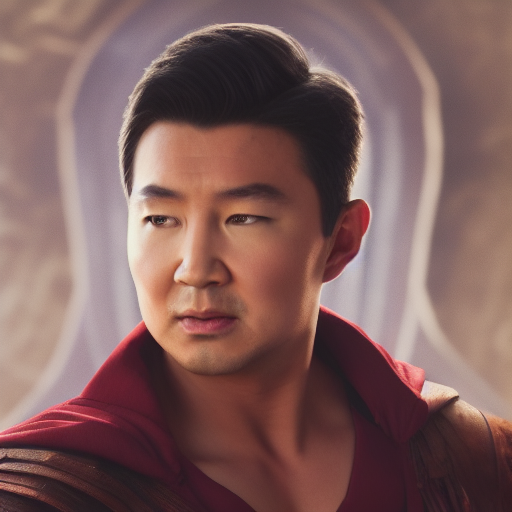

In [16]:
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
#     "cuda"
# )
import random
tune_lora_scale(pipe.unet, 1)
tune_lora_scale(pipe.text_encoder, 1)

prompt = "closeup detailed portrait of <sl2> man as superman, by greg rutkowski, alphonse mucha, trending on artstation, 8k, highly detailed"
# prompt = "closeup detailed portrait of <x1> girl as superwoman, by greg rutkowski, alphonse mucha, trending on artstation, 8k, highly detailed"
# prompt = "closeup portrait of <sl2> man"
torch.manual_seed(random.randint(0,15999))
image = pipe(prompt, num_inference_steps=20, guidance_scale=4.5).images[0]

image